# "Hello world" in Keras

A few months ago, I started a new job doing applied research at Fast Forward Labs. My new colleagues had just finished a project on image recongition with convolutional neural networks, and were starting on a new project on text summarization with recurrent neural networks. Neural networks were not something I'd previously worked with, so I knew I'd have to get up to speed fast.

Despite all the recent excitement around deep learning, neural networks have a somewhat deserved reputation among non-specialists, who view them as computationally intensive to train and apply, difficult to interpret, and tedious to build.

That was certainly my feeling. And while interpretability remains an issue, and you're going to want access to some pretty serious hardware to train and deploy large networks, the process of building and experimenting with neural networks has gotten a lot easier recently.

That's because there are now _high-level_ neural network libraries that enable developers to quickly build neural network models without worrying about the numerical details of floating point operations, tensor algebra and GPU programming.

Today we're going to look at one of these libraries, Keras. Keras is a high-level neural network library that, among many other things, wraps an API similar to scikit-learn's around the Theano or TensorFlow backends.

Because of that similarity with scikit-learn, and to emphasise that neural network design and testing is now accessible to everyone, I'm going to give you a quick tutorial on how to use Keras by explicitly comparing it to scikit-learn

Scikit-learn is the most popular, feature-complete classical machine learning library used by Python developers. Among the many great things about Scikit-learn, my favourite is its simple, coherent and consistent API, which is built around `Estimator` objects. The API is a good description of machine learning workflow with which many engineers are already comfortable with, and it's consistently applied throughout the package.

Let's get started by importing the libraries we'll need: scikit-learn, Keras and some plotting features.

In [11]:
#!pip install keras
#!pip install seaborn
#!pip install tensorflow

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegressionCV

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.utils import np_utils

Using TensorFlow backend.


# Iris data

The famous [iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) (published by Ronald Fisher in 1936) is a great way of demonstrating the API of a machine learning framework. In some ways it's the "Hello world" of machine learning.

The data is simple, and it's possible to get high accuracy with an extremely simple classifier. Using a neural network to solve this problem is therefore using a sledghammer to crack a nut. But this is fine! Our goal is to explore the code required to get from data to working classifier, not the details of model design and selection.

The iris dataset is built into many machine learning libraries. I like the copy in `seaborn` because it comes as a labelled dataframe that can be easily visualized, and we're using seaborn anyway, so let's load it from there and look at the first 5 examples.

In [12]:
iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


<img src="https://github.com/fastforwardlabs/keras-hello-world/raw/f304c056c53b2eaa3402d49702a54a7f8a0368a0/Iris_sanguinea.JPG" alt="An Iris" style="width: 400px;"/>

For each example (i.e., flower), there are five pieces of data. Four are standard measurements of the flower's size (in centimeters), and the fifth is the species of iris. There are three species: setosa, verscicolor and virginica. Our job is to build a classifier that, given the two petal and two sepal measurements, can predict the species of an iris. Let's do a quick visualization before we start model building (always a good idea!):

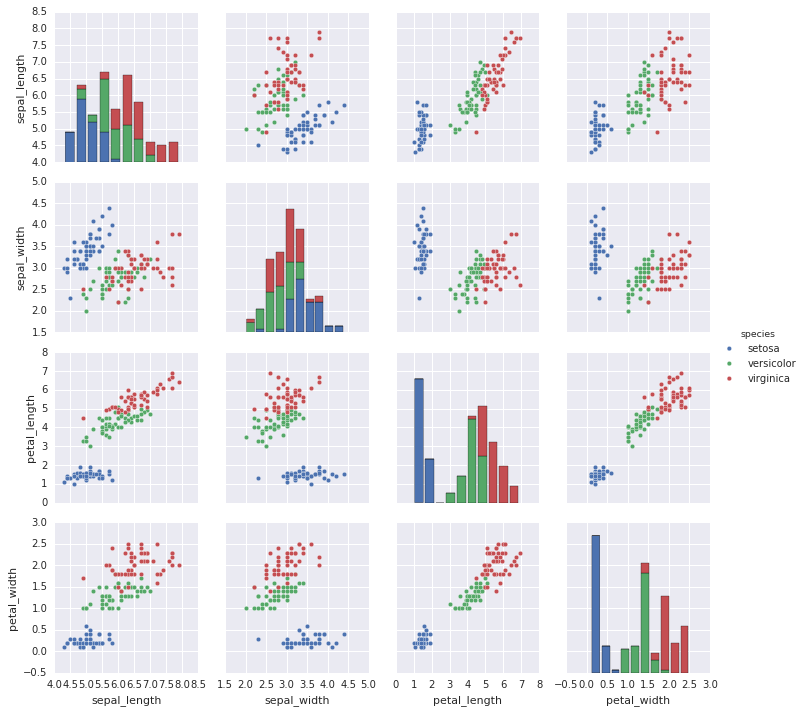

In [13]:
sns.pairplot(iris, hue='species');

# Munge and split the data for training and testing

First we need to pull the raw data out of the `iris` dataframe. We'll hold the petal and sepal data in an array `X` and the species labels in a corresponding array `y`.

In [14]:
X = iris.values[:, :4]
y = iris.values[:, 4]

As is standard in supervised machine learning, we'll train with some of the data, and measure the performance of our model with the remainder. This is simple to do by hand, but is also built into scikit-learn as the `train_test_split()` function.

In [15]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.5, random_state=0)

# Train a scikit-learn classifier

We'll train a logisitic regression classifier. Doing this, with built-in hyper-paramter cross validation, is one line in scikit-learn. Like all scikit-learn `Estimator` objects, a `LogisticRegressionCV` classifier has a `.fit()` method that takes care of the gory numerical details of learning model parameters that best fit the training data. So that method is all we need to do:

In [16]:
lr = LogisticRegressionCV()
lr.fit(train_X, train_y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

# Assess the classifier using accuracy

Now we can measure the fraction of of the test set the trained classifer classifies correctly (i.e., accuracy).

In [17]:
print("Accuracy = {:.2f}".format(lr.score(test_X, test_y)))

Accuracy = 0.83


# Now do something very similar with Keras

Keras is a high-level neural network library created by [François Chollet](https://twitter.com/fchollet) at Google. The initial commit to its public Github repository was March 27 last year, so it's a year old.

As we just saw, scikit-learn makes building a classifier very simple:
 - one line to instantiate the classifier
 - one line to train it
 - and one line to measure its performance
 
Building a classifier is only a little bit more complicated in Keras. The data-munging changes a little bit, and we have to do some work to define the network before we instantiate it as a classifier, but otherwise it's very similar to working with scikit-learn.

First a bit of data-munging: scikit-learn's classifiers accept string labels, e.g. `"setosa"`. But `keras` requires that labels be one-hot-encoded. This means we need to convert data that looks like

```
setosa
versicolor
setosa
virginica
...
```

to a table that looks like

```
setosa versicolor virginica
     1          0         0
     0          1         0
     1          0         0
     0          0         1
```

There are lots of ways of doing this. If you're a pandas person then there's `pandas.get_dummies()`, and one-hot-encoding is in scikit-learn. We'll just use a Keras utility and some numpy.

In [18]:
def one_hot_encode_object_array(arr):
    '''One hot encode a numpy array of objects (e.g. strings)'''
    uniques, ids = np.unique(arr, return_inverse=True)
    return np_utils.to_categorical(ids, len(uniques))

train_y_ohe = one_hot_encode_object_array(train_y)
test_y_ohe = one_hot_encode_object_array(test_y)

# Build the neural network model

Aside from the data munging required in this particular case, the most signifcant and important difference with working with Keras is that you have to specify the structure of the model before you can instantiate and use it.

In scikit-learn, the models are off-the-shelf. But Keras is a neural network library. As such, while the number of features/classes in your data provide constraints, you can determine all the other aspects of model structure: number of layers, size of layers, the nature of the connections between the layers, etc. (And if that didn't make sense, Keras is a great way to experiment with it!)

The upshot of this freedom is that instaniating a minimal classifier involves a bit more work than the one line required by scikit-learn.

In our case, we'll build an extremely simple network. Two of the choices are made for us by the data. We have four features and three classes, so the input layer must have four units, and the output layer must have three units. We only have to define the hidden layers. We're only going to have one hidden layer for this project, and we'll give it 16 units. From the point of view of a GPU, 16 is a round number! You'll see a lot of powers of 2 when you work with neural networks.

We're going to define our model in the most common way: as a sequential stack of layers. The alternative is as a computational graph, but we're going to stick to `Sequential()` here.

In [19]:
model = Sequential()

The next two lines define the size input layer (input_shape=(4,), and the size and activation function of the hidden layer

In [20]:
model.add(Dense(16, input_shape=(4,)))
model.add(Activation('sigmoid'))

... and the next line defines the size and activation function of the ouput layer.

In [21]:
model.add(Dense(3))
model.add(Activation('softmax'))

Finally we specify the optimization strategy and the loss function to optimize. We also instruct the model to calculate accuracy as it works.

In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

# Use the neural network classifier

Now we've defined the structure model and compiled it, we have an object whose API is almost identical to a classifier in scikit-learn. In particular, it has `.fit()` and `.predict()` methods. Let's `fit`.

Training neural networks often involves the concept of "minibatching", which means showing the network a subset of the data, adjusting the weights, and then showing it another subset of the data. When the network has seen all the data once, that's called an "epoch". Tuning the minibatch/epoch strategy is a somewhat problem-specific issue, but in this case we'll just use a minibatch of 1. That makes it effectively good old stochastic gradient descent, i.e. the data is shown to the network one flower at a time, and the weights adjusted immediately.

Feel free to rerun this cell with `verbose=0` removed. Note that if you want to experiment with the minibatch/epoch strategy you should rerun the previous cell that ran `model.compile()` to reinitialize the model weights.

In [23]:
model.fit(train_X, train_y_ohe, nb_epoch=100, batch_size=1, verbose=0);

For basic use, the only syntactic API difference between a compiled keras model and a scikit-learn classifier is that Keras's equivalent of the scikit-learn `.score()` method is called `.evaluate()`. 

`evaluate()` returns the loss function and any other metrics we asked for when we compiled the model. In our case, we asked for `accuracy`, which we can compare to the accuracy we got from the `.score()` method of our scikit-learn `LogisticRegressionCV` classifier.

In [24]:
loss, accuracy = model.evaluate(test_X, test_y_ohe, verbose=0)
print("Accuracy = {:.2f}".format(accuracy))

Accuracy = 0.99


As you can see, the test accuracy of the neural network model is better than that of the simple logistic regression classifier.

This is reassuring but not surprising. Even our very simple neural network has the flexibility to learn much more complicated classification surfaces than logisitic regression, so of course it does better than logisitic regression.

And it does hint at one of the dangers of neural networks: overfitting. We've been careful here to hold out a test set and measure performance with that, but it's a small set, and 99% accuracy seems awfully high to me, so I wouldn't be surprised if there was some overfitting going on. You could work on that by adding dropout (which is built in to Keras). That's the neural network equivalent of the regularization our LogisticRegression classifier uses.

But we'll stop here, because a neural network model is overkill for this problem, and worrying about accuracy is not the point of what I've shown you. The point is that using a batteries-included, high-level library like Keras means that we need to write only a little bit more code to build, train, and apply a neural network model than a traditional model.

# What next?

We built an extremely simple feed-forward network model. To experiment more, load the [MNIST database of handwritten digits](http://keras.io/datasets/) and see if you can beat a standard scikit-learn classifier. Unlike the Iris dataset, this is a situation where the power and relative complexity of neural networks is justified. Try it yourself first, but if you get stuck, take a look at [this notebook](https://github.com/wxs/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb).

Technical and engineering tutorials for your favourite language or library are easy to find, but if you're interested in some of the more conceptual and mathematical background, take a look at:
 - Michael Nielsen's online textbook "[Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/)" (especially chapters 1, 2 and 3)
 - Weeks 4 and 5 of Andrew Ng's Coursera course "[Machine Learning](https://www.coursera.org/learn/machine-learning)" (you'll have to sign up for the course to access these materials)
 - "[Deep Learning](http://www.nature.com/nature/journal/v521/n7553/abs/nature14539.html)" by Yan Le Cun et al. in Nature (2015) (you can find a [PDF of this article on Google Scholar](https://scholar.google.com/scholar?cluster=5362332738201102290))
 - Chris Olah's [wonderful essays](http://colah.github.io/), particularly the ones on [back propagation](http://colah.github.io/posts/2015-08-Backprop/) (the algorithm with which neural networks are trained) and [recurrent neural networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).

Speaking of recurrent neural networks, Keras also has layers that allow you to build models with:

 - convolutional layers, which give state-of-the-art results for computer vsion problems;
 - recurrent layers, which are particularly well suited to modelling language and other sequence data.
 
In fact, one key strength of neural networks (along with sheer predictive power) is their composability. Using a high-level library like Keras, it takes only a few seconds of work to create a very different network. Models can be built up like Lego. Have fun!